## 1. Import the required libraries

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = 'False'
import sys
import configparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import random
from tqdm import tqdm
from functools import partial

import torch
from torch.backends import cudnn

import torchvision
from torchvision import transforms

sys.path.insert(0, '../MODULES')
from DENOISING_DIFFUSION_PYTORCH import Unet, GaussianDiffusion

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Write device agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


## 3. Fix hyperparameters

In [3]:
config = configparser.ConfigParser()

config['diffusion_model'] = {'rand_seed': 76543, 'n_pix': 128, 'batch_size': 10, 'learning_rate': 1e-4, 'h_dim': 64,
                             'dim_mults': [1, 2, 4, 8], 'self_condition': False, 'timesteps': 1000}

config.write(sys.stdout)

[diffusion_model]
rand_seed = 76543
n_pix = 128
batch_size = 10
learning_rate = 0.0001
h_dim = 64
dim_mults = [1, 2, 4, 8]
self_condition = False
timesteps = 1000



## 4. Set hyperparameters

In [4]:
rand_seed = int(config['diffusion_model']['rand_seed'])

random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.random.manual_seed(rand_seed)

if device == 'cuda':
    torch.cuda.manual_seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [5]:
n_pix         = int(config['diffusion_model']['n_pix'])
batch_size    = int(config['diffusion_model']['batch_size'])
learning_rate = float(config['diffusion_model']['learning_rate'])
h_dim         = int(config['diffusion_model']['h_dim'])

In [6]:
match = re.search('\[(.*)\]', config['diffusion_model']['dim_mults'])
dim_mults = re.split(',\s*', match[1])
dim_mults = [int(i) for i in dim_mults]

In [7]:
self_condition = bool(config['diffusion_model']['self_condition'])
timesteps      = int(config['diffusion_model']['timesteps'])

## 5. Instantiate Unet

In [8]:
model = Unet(dim=h_dim, dim_mults=dim_mults, self_condition=self_condition, flash_attn=True)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


## 6. Instantiate diffusion model

In [9]:
diffusion = GaussianDiffusion(model, image_size=n_pix, timesteps=timesteps, objective='pred_noise', beta_schedule='cosine',
                              auto_normalize=False).to(device)

## 7. Custom function to make a grid of images

In [10]:
def make_img_grid(xxx):
    img = torchvision.utils.make_grid(xxx, padding=5)
    img = transforms.functional.to_pil_image(img)
    return img

## 8. Load diffusion model

In [11]:
dir_save = '../P2'

path_model = os.path.join(dir_save, 'model_ddpm.20240508.150.ckpt')
path_hist = os.path.join(dir_save, 'hist_ddpm.20240508.150.tsv')

diffusion.model.load_state_dict(torch.load(path_model, weights_only=True))

<All keys matched successfully>

## 9. Plot diffusion model loss

In [12]:
hist_tt = pd.read_csv('hist_ddpm.20240508.150.tsv', sep='\t')

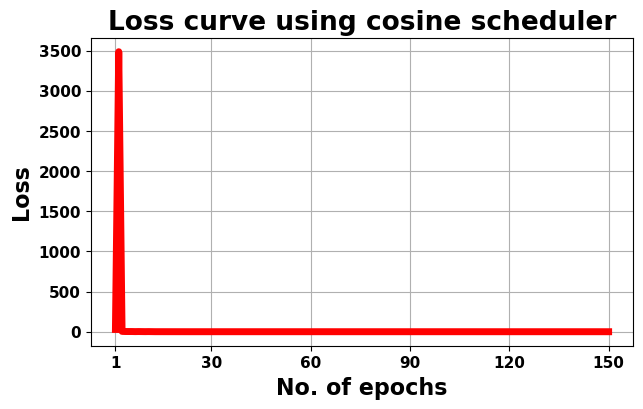

In [13]:
N = [x+1 for x in hist_tt['tt']]

plt.figure(figsize=(7, 4))
plt.plot(N, hist_tt['loss_trn'], color='r', linewidth=5)
plt.xlabel('No. of epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.title('Loss curve using cosine scheduler', fontsize=19, fontweight='bold')
plt.xticks([1, 30, 60, 90, 120, 150], fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid();

## 10. Plot `betas`

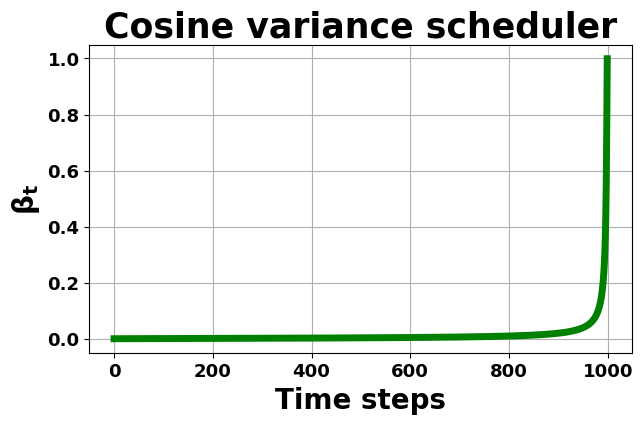

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(diffusion.betas.detach().cpu(), color='g', linewidth=5)
plt.xlabel('Time steps', fontsize=20, fontweight='bold')
plt.ylabel(r'$\mathbf{β_t}$', fontsize=20)
plt.title('Cosine variance scheduler', fontsize=25, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.grid();

## 11. Plot `alphas_cumprod`

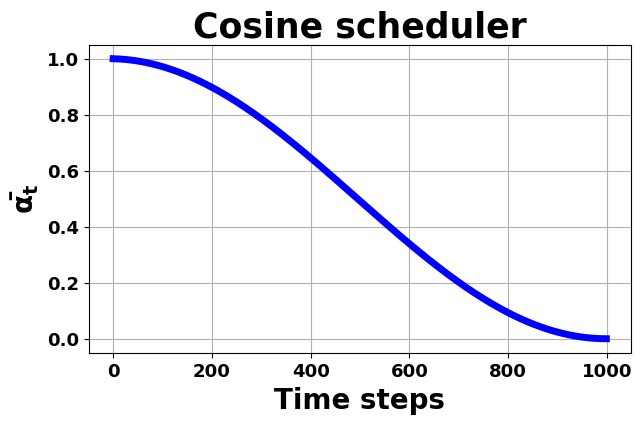

In [15]:
plt.figure(figsize=(7, 4))
plt.plot(diffusion.alphas_cumprod.detach().cpu(), linewidth=5, color='b')
plt.xlabel('Time steps', fontsize=20, fontweight='bold')
plt.ylabel(r'$\mathbf{\bar{α_t}}$', fontsize=20)
plt.title('Cosine scheduler', fontsize=25, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.grid();

## 12. Reverse process output

In [16]:
img = torch.randn(10, 3, 128, 128).to(device)
clip_func = partial(torch.clamp, min=0., max=1.)

In [17]:
times = np.arange(-1, 1000) # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
times = np.flip(times)
time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

In [18]:
eta = 0.0
img_seq = []

with torch.inference_mode():
    img_seq.append(img.cpu().detach().numpy())
    
    for time, time_next in tqdm(time_pairs, desc='reverse_process_output'):
        time_cond = torch.full((batch_size,), time, dtype=torch.long).to(device)
        
        model_output = model(img, time_cond, x_self_cond=None)
        
        pred_noise = model_output
        x_start = diffusion.predict_start_from_noise(img, time_cond, pred_noise)
        x_start = clip_func(x_start)
        
        if time_next < 0:
            img_seq.append(x_start.detach().cpu().numpy())
            continue
            
        alpha = diffusion.alphas_cumprod[time]
        alpha_next = diffusion.alphas_cumprod[time_next]
        
        sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
        c = (1 - alpha_next - sigma ** 2).sqrt()
        
        noise = torch.randn_like(img)
        
        img = x_start * alpha_next.sqrt() + c * pred_noise + sigma * noise
        if (time % 100 == 0):
            img_seq.append(img.detach().cpu().numpy())

reverse_process_output: 100%|███████████████████████████████████| 1000/1000 [00:58<00:00, 17.17it/s]


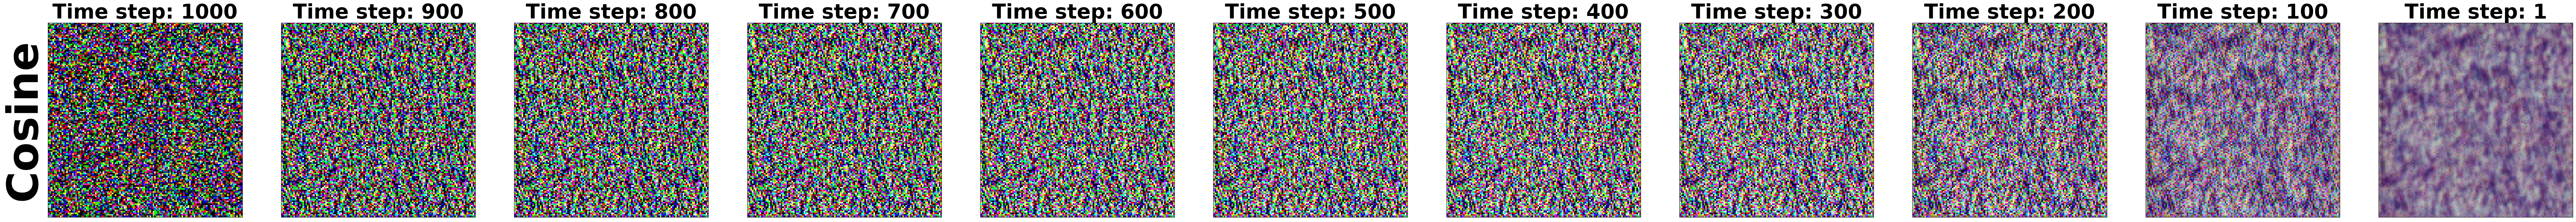

In [19]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]

fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for p, q in enumerate(img_seq):
    ax[p].imshow(np.clip(q[0], 0, 1).transpose())
    ax[p].set_title(f'Time step: {step[p]}', fontsize=45, fontweight='bold')
    ax[0].set_ylabel('Cosine', fontsize=95, fontweight='bold')
    ax[p].set_xticks([])
    ax[p].set_yticks([]);

## 13. Random sampling 

In [20]:
rand_samp = diffusion.sample(64)

sampling loop time step: 100%|██████████████████████████████████| 1000/1000 [05:39<00:00,  2.95it/s]


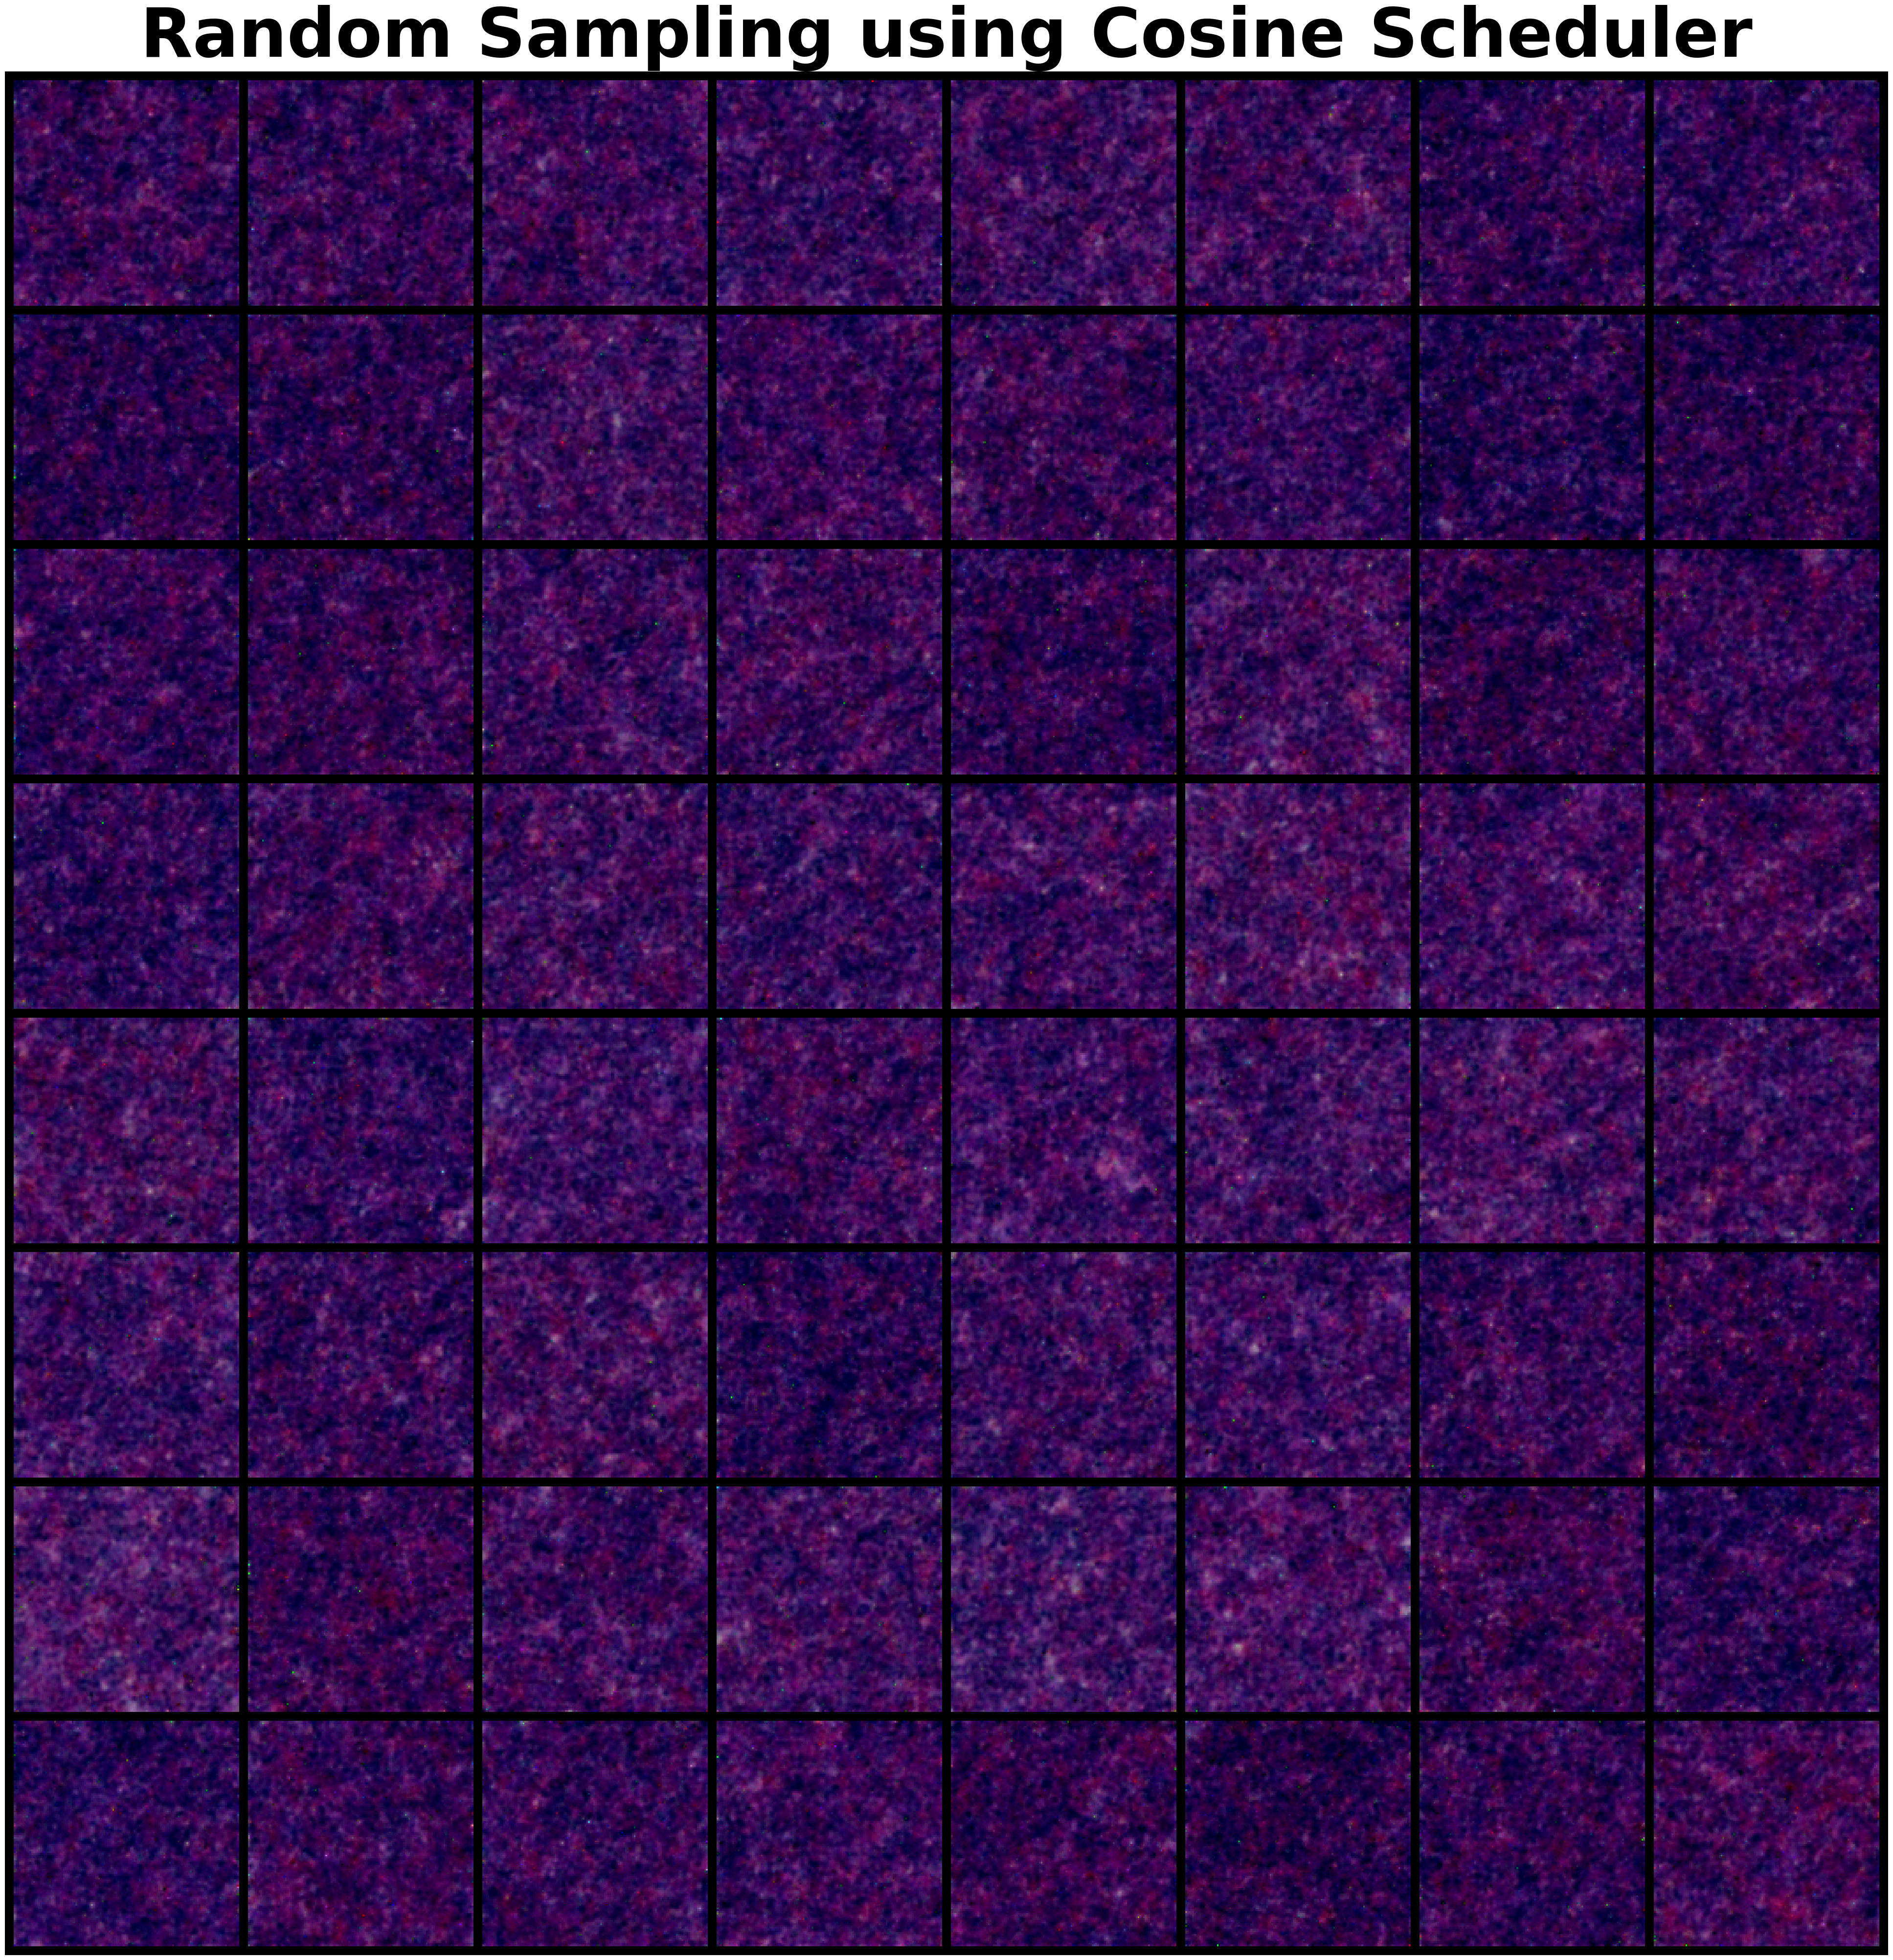

In [21]:
img_tmp = make_img_grid(clip_func(rand_samp))

plt.figure(figsize=(50, 50))
plt.imshow(img_tmp)
plt.axis(False)
plt.title('Random Sampling using Cosine Scheduler', fontsize=100, fontweight='bold');